In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, mean_squared_error 

file_path1 = "/Users/zhengguangyuan/Downloads/CDS521_Dissertation_Dataset/FashionMNIST0.3.npz"
file_path2 = "/Users/zhengguangyuan/Downloads/2CDS521_Dissertation_Dataset/FashionMNIST0.6.npz"
file_path3 = "/Users/zhengguangyuan/Downloads/CDS521_Dissertation_Dataset/CIFAR10.npz"
dataset1 = np.load(file_path1)
dataset2 = np.load(file_path2)
dataset3 = np.load(file_path3)
print(f"Keys in FashionMNIST0.3.npz: {list(dataset1.keys())}")
print(f"Keys in FashionMNIST0.6.npz: {list(dataset2.keys())}")
print(f"CIFAR10.npz: {list(dataset3.keys())}")

Keys in FashionMNIST0.3.npz: ['X_tr', 'S_tr', 'X_ts', 'Y_ts']
Keys in FashionMNIST0.6.npz: ['X_tr', 'S_tr', 'X_ts', 'Y_ts']
CIFAR10.npz: ['X_tr', 'S_tr', 'X_ts', 'Y_ts']


# FashionMNIST0.3

(24000, 28, 28)
(24000,)
(4000, 28, 28)
(4000,)
Test set contains 4 unique labels: [0 1 2 3]
Train set contains 4 unique labels: [0 1 2 3]


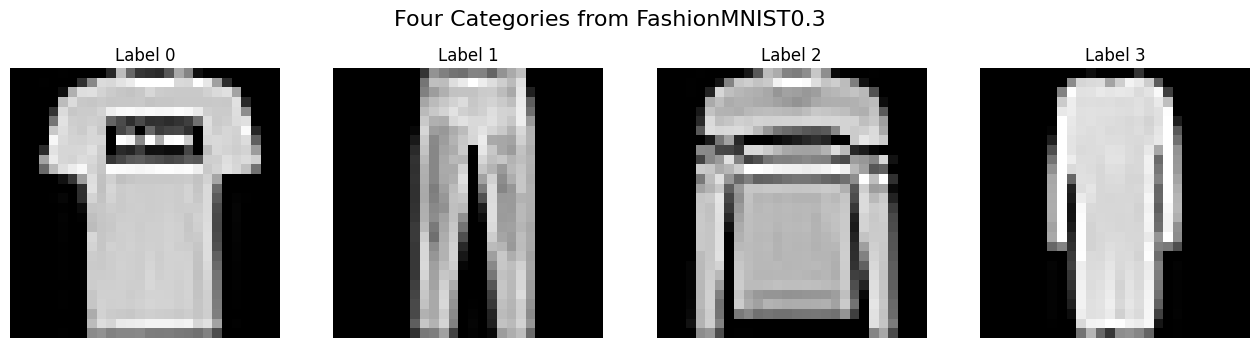

In [3]:
# Extracting the training and test sets for features and labels
Xtr = dataset1['X_tr']  # Training feature set
Str = dataset1['S_tr']  # Training label set
Xts = dataset1['X_ts']  # Test feature set
Yts = dataset1['Y_ts']  # Test label set

# Printing the shape of each set to check data dimensions
print(Xtr.shape)  
print(Str.shape)  
print(Xts.shape)  
print(Yts.shape) 

# Checking unique labels in the test set and printing them
unique_labels = np.unique(Yts)
print(f"Test set contains {len(unique_labels)} unique labels: {unique_labels}")

# Checking unique labels in the training set and printing them
unique_labels = np.unique(Str)
print(f"Train set contains {len(unique_labels)} unique labels: {unique_labels}")

# Visualizing four categories from the training set with corresponding labels
images = Xtr  
unique_labels = np.unique(Str)  

# Setting up a plot with 1 row and 4 columns
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Looping through unique labels to display one image per label
for i, label in enumerate(unique_labels):
    # Finding the first occurrence of the current label in the training set
    image_idx = np.where(Str == label)[0][0]
    
    # Displaying the image corresponding to the current label
    axes[i].imshow(images[image_idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Label {label}')  # Adding title for each image
    axes[i].axis('off')  # Removing axis for a cleaner look

# Adding a title for the overall plot
plt.suptitle('Four Categories from FashionMNIST0.3', fontsize=16)
plt.show()  # Displaying the plot


In [4]:
def standard_cross_entropy_loss_with_importance(output, target, transition_matrix, class_weights):
    # Get softmax output
    output = F.softmax(output, dim=1)
    # Adjust the predicted distribution using the transition matrix
    noisy_output = torch.matmul(output, transition_matrix)
    # Compute weighted cross-entropy loss with the corrected output
    one_hot_target = F.one_hot(target, num_classes=4)
    weighted_loss = -torch.sum(class_weights * one_hot_target * torch.log(noisy_output), dim=1).mean()

    return weighted_loss

# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 6 * 6, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 6 * 6)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Set device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [5]:
n_iterations = 10
cnn_accuracies = []
mlp_accuracies = []

transition_matrix1 = np.array([[0.7, 0.3, 0, 0],
                               [0, 0.7, 0.3, 0],
                               [0, 0, 0.7, 0.3],
                               [0.3, 0, 0, 0.7]])
transition_matrix1_t = torch.tensor([[0.7, 0.3, 0, 0],
                                     [0, 0.7, 0.3, 0],
                                     [0, 0, 0.7, 0.3],
                                     [0.3, 0, 0, 0.7]], dtype=torch.float32).to(device)

# Smoothing off-diagonal elements
for i in range(transition_matrix1_t.size(0)):
    for j in range(transition_matrix1_t.size(1)):
        if i != j and transition_matrix1_t[i, j] > 0.2:
            transition_matrix1_t[i, j] = 0.2

# Main training loop
for i in range(n_iterations):
    a = 0
    X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=a)
    a = a + 1
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_val = X_val.reshape(-1, 1, 28, 28)
    Xts_reshaped = Xts.reshape(-1, 1, 28, 28)

    X_train = X_train / 255.0
    X_val = X_val / 255.0
    Xts_reshaped = Xts_reshaped / 255.0

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    Xts_tensor = torch.tensor(Xts_reshaped, dtype=torch.float32).to(device)
    Yts_tensor = torch.tensor(Yts, dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    test_loader = DataLoader(TensorDataset(Xts_tensor, Yts_tensor), batch_size=128, shuffle=False)

    # Assuming y_train contains labels for all training samples
    num_classes = 4
    class_counts = np.bincount(y_train, minlength=num_classes)  # Count the frequency of each class
    total_samples = len(y_train)

    # Compute class weights
    class_weights = total_samples / (num_classes * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # CNN Training
    cnn_model = CNN().to(device)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

    cnn_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_cnn.zero_grad()
            outputs = cnn_model(inputs)
            # Using custom loss function with importance weighting and transition matrix
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, transition_matrix1_t, class_weights)
            loss.backward()
            optimizer_cnn.step()

    # Evaluating CNN on test set
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Top-1 accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    cnn_accuracy = correct / total
    cnn_accuracies.append(cnn_accuracy)

    # MLP Training
    mlp_model = MLP().to(device)
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

    mlp_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_mlp.zero_grad()
            outputs = mlp_model(inputs)
            # Using custom loss function with importance weighting and transition matrix
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, transition_matrix1_t, class_weights)
            loss.backward()
            optimizer_mlp.step()

    # Evaluating MLP on test set
    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs.data, 1)  # Top-1 accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    mlp_accuracy = correct / total
    mlp_accuracies.append(mlp_accuracy)

# Calculate and print accuracy statistics for CNN
mean_accuracy_cnn1 = np.mean(cnn_accuracies)
std_accuracy_cnn1 = np.std(cnn_accuracies)
best_accuracy_cnn1 = np.max(cnn_accuracies)
print("CNN Training completed.")
print(f"FashionMNIST0.3 average CNN Test Accuracy over {n_iterations} iterations: {mean_accuracy_cnn1:.4f}")
print(f"FashionMNIST0.3 standard Deviation of CNN Test Accuracy over {n_iterations} iterations: {std_accuracy_cnn1:.4f}")
print(f"FashionMNIST0.3 highest CNN Test Accuracy during iterations: {best_accuracy_cnn1:.4f}")

# Calculate and print accuracy statistics for MLP
mean_accuracy_mlp1 = np.mean(mlp_accuracies)
std_accuracy_mlp1 = np.std(mlp_accuracies)
best_accuracy_mlp1 = np.max(mlp_accuracies)
print("MLP Training completed.")
print(f"FashionMNIST0.3 average MLP Test Accuracy over {n_iterations} iterations: {mean_accuracy_mlp1:.4f}")
print(f"FashionMNIST0.3 standard Deviation of MLP Test Accuracy over {n_iterations} iterations: {std_accuracy_mlp1:.4f}")
print(f"FashionMNIST0.3 highest MLP Test Accuracy during iterations: {best_accuracy_mlp1:.4f}")


CNN Training completed.
FashionMNIST0.3 average CNN Test Accuracy over 10 iterations: 0.9585
FashionMNIST0.3 standard Deviation of CNN Test Accuracy over 10 iterations: 0.0035
FashionMNIST0.3 highest CNN Test Accuracy during iterations: 0.9625
MLP Training completed.
FashionMNIST0.3 average MLP Test Accuracy over 10 iterations: 0.9442
FashionMNIST0.3 standard Deviation of MLP Test Accuracy over 10 iterations: 0.0024
FashionMNIST0.3 highest MLP Test Accuracy during iterations: 0.9480


# FashionMNIST0.6

(24000, 28, 28)
(24000,)
(4000, 28, 28)
(4000,)
Test set contains 4 unique labels: [0 1 2 3]
Train set contains 4 unique labels: [0 1 2 3]


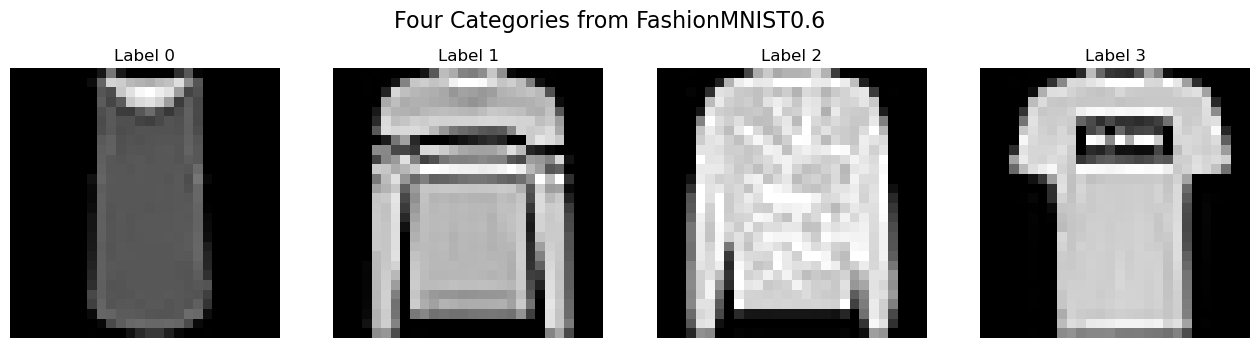

In [6]:
# Extract training and test sets for features and labels from dataset2
Xtr = dataset2['X_tr']  
Str = dataset2['S_tr']  
Xts = dataset2['X_ts'] 
Yts = dataset2['Y_ts']  

# Print the shape of each dataset to verify dimensions
print(Xtr.shape)
print(Str.shape)
print(Xts.shape)
print(Yts.shape)

# Display unique labels in the test set
unique_labels = np.unique(Yts)
print(f"Test set contains {len(unique_labels)} unique labels: {unique_labels}")

# Display unique labels in the training set
unique_labels = np.unique(Str)
print(f"Train set contains {len(unique_labels)} unique labels: {unique_labels}")

# Visualize four categories from the training set based on unique labels
images = Xtr  
unique_labels = np.unique(Str)  

# Set up a plot with 1 row and 4 columns for displaying images
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(unique_labels):
    # Find the index of the first occurrence of each label
    image_idx = np.where(Str == label)[0][0]  
    # Display the corresponding image
    axes[i].imshow(images[image_idx].reshape(28, 28), cmap='gray')
    axes[i].set_title(f'Label {label}')
    axes[i].axis('off')  # Remove axis for a cleaner look

# Add a main title to the plot
plt.suptitle('Four Categories from FashionMNIST0.6', fontsize=16)
plt.show()


In [7]:
n_iterations = 10
cnn_accuracies = []
mlp_accuracies = []


transition_matrix2 = np.array([[0.4, 0.2, 0.2, 0.2],
                              [0.2, 0.4, 0.2, 0.2],
                              [0.2, 0.2, 0.4, 0.2],
                              [0.2, 0.2, 0.2, 0.4]]) 
transition_matrix2_t = torch.tensor([[0.4, 0.2, 0.2, 0.2],
                                    [0.2, 0.4, 0.2, 0.2],
                                    [0.2, 0.2, 0.4, 0.2],
                                    [0.2, 0.2, 0.2, 0.4]], dtype=torch.float32).to(device)

# Smooth non-diagonal elements
for i in range(transition_matrix2_t.size(0)):
    for j in range(transition_matrix2_t.size(1)):
        if i != j and transition_matrix2_t[i, j] > 0.2:
            transition_matrix1_t[i, j] = 0.2

# Main training cycle
for i in range(n_iterations):
    a = 0
    X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=a)
    a = a+1
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_val = X_val.reshape(-1, 1, 28, 28)
    Xts_reshaped = Xts.reshape(-1, 1, 28, 28)

    X_train = X_train / 255.0
    X_val = X_val / 255.0
    Xts_reshaped = Xts_reshaped / 255.0

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    Xts_tensor = torch.tensor(Xts_reshaped, dtype=torch.float32).to(device)
    Yts_tensor = torch.tensor(Yts, dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    test_loader = DataLoader(TensorDataset(Xts_tensor, Yts_tensor), batch_size=128, shuffle=False)
    
    # Suppose y_train contains labels for all training samples
    num_classes = 4
    class_counts = np.bincount(y_train, minlength=num_classes)  # 计算每个类别的频率
    total_samples = len(y_train)

    # Calculate class weights
    class_weights = total_samples / (num_classes * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # CNN Training
    cnn_model = CNN().to(device)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

    cnn_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_cnn.zero_grad()
            outputs = cnn_model(inputs)
            # Use a custom loss function with importance weighting and transition matrix
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, transition_matrix2_t, class_weights)
            loss.backward()
            optimizer_cnn.step()

    # Evaluate CNN on the test set
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    cnn_accuracy = correct / total
    cnn_accuracies.append(cnn_accuracy)
    


    # MLP training
    mlp_model = MLP().to(device)
    # Change the optimizer to Adam and set the learning rate to 0.001
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

    mlp_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_mlp.zero_grad()
            outputs = mlp_model(inputs)
            # Use a custom loss function with importance weighting and transition matrix
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, transition_matrix2_t, class_weights)
            loss.backward()
            optimizer_mlp.step()

    # Evaluate MLP on test set
    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    mlp_accuracy = correct / total
    mlp_accuracies.append(mlp_accuracy)
    
    
mean_accuracy_cnn2 = np.mean(cnn_accuracies)
std_accuracy_cnn2 = np.std(cnn_accuracies)
best_accuracy_cnn2 = np.max(cnn_accuracies)
print("CNN Training completed.")
print(f"FashionMNIST0.6 average CNN Test Accuracy over {n_iterations} iterations: {mean_accuracy_cnn2:.4f}")
print(f"FashionMNIST0.6 standard Deviation of CNN Test Accuracy over {n_iterations} iterations: {std_accuracy_cnn2:.4f}")
print(f"FashionMNIST0.6 highest CNN Test Accuracy during iterations: {best_accuracy_cnn2:.4f}")

mean_accuracy_mlp2 = np.mean(mlp_accuracies)
std_accuracy_mlp2 = np.std(mlp_accuracies)
best_accuracy_mlp2 = np.max(cnn_accuracies)
print("MLP Training completed.")
print(f"FashionMNIST0.6 average MLP Test Accuracy over {n_iterations} iterations: {mean_accuracy_mlp2:.4f}")
print(f"FashionMNIST0.6 standard Deviation of MLP Test Accuracy over {n_iterations} iterations: {std_accuracy_mlp2:.4f}")
print(f"FashionMNIST0.6 highest MLP Test Accuracy during iterations: {best_accuracy_mlp2:.4f}")

CNN Training completed.
FashionMNIST0.6 average CNN Test Accuracy over 10 iterations: 0.9171
FashionMNIST0.6 standard Deviation of CNN Test Accuracy over 10 iterations: 0.0111
FashionMNIST0.6 highest CNN Test Accuracy during iterations: 0.9293
MLP Training completed.
FashionMNIST0.6 average MLP Test Accuracy over 10 iterations: 0.8991
FashionMNIST0.6 standard Deviation of MLP Test Accuracy over 10 iterations: 0.0148
FashionMNIST0.6 highest MLP Test Accuracy during iterations: 0.9293


# Verify the Transfer Matrix Estimator

In [8]:
def estimate_transition_matrix(y_true, y_pred, num_classes):
    # Initialize an empty transition matrix with dimensions (num_classes x num_classes)
    transition_matrix = torch.zeros((num_classes, num_classes))
    
    # Populate the transition matrix by counting occurrences of each true-predicted label pair
    for i in range(len(y_true)):
        true_label = y_true[i]
        pred_label = y_pred[i]
        transition_matrix[true_label, pred_label] += 1

    # Normalize each row to sum to 1
    transition_matrix = transition_matrix / transition_matrix.sum(dim=1, keepdim=True)
    return transition_matrix

def validate_transition_estimator(T_true, T_estimated):
    # Calculate Mean Absolute Error (MAE) between true and estimated transition matrices
    mae = mean_absolute_error(T_true.flatten(), T_estimated.flatten())
    # Calculate Mean Squared Error (MSE) between true and estimated transition matrices
    mse = mean_squared_error(T_true.flatten(), T_estimated.flatten())
    return mae, mse


In [9]:
Xtr = dataset1['X_tr']
Str = dataset1['S_tr']
Xts = dataset1['X_ts']
Yts = dataset1['Y_ts']

X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=5328)
X_train = X_train.reshape(-1, 1, 28, 28)
X_val = X_val.reshape(-1, 1, 28, 28)
Xts_reshaped = Xts.reshape(-1, 1, 28, 28)

X_train = X_train / 255.0
X_val = X_val / 255.0
Xts_reshaped = Xts_reshaped / 255.0

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128, shuffle=False)


model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_classes=4
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # Do not print the transition matrix for each epoch during training, ensure that only the last transition matrix is recorded
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

# Use T-revision to estimate the transition matrix T1 at the last time
T1 = estimate_transition_matrix(all_labels, all_preds, num_classes=4)
print("Final Transition Matrix of T1:\n", T1)

Final Transition Matrix of T1:
 tensor([[0.7121, 0.0090, 0.0164, 0.2625],
        [0.2844, 0.6804, 0.0180, 0.0172],
        [0.0202, 0.3030, 0.6599, 0.0168],
        [0.0643, 0.0057, 0.2913, 0.6387]])


In [10]:
Xtr = dataset2['X_tr']
Str = dataset2['S_tr']
Xts = dataset2['X_ts']
Yts = dataset2['Y_ts']

X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=5328)
X_train = X_train.reshape(-1, 1, 28, 28)
X_val = X_val.reshape(-1, 1, 28, 28)
Xts_reshaped = Xts.reshape(-1, 1, 28, 28)

X_train = X_train / 255.0
X_val = X_val / 255.0
Xts_reshaped = Xts_reshaped / 255.0

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128, shuffle=False)

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_classes=4
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            
T2 = estimate_transition_matrix(all_labels, all_preds, num_classes=4)
print("Final Transition Matrix of T2:\n", T2)

Final Transition Matrix of T2:
 tensor([[0.3800, 0.1871, 0.1969, 0.2360],
        [0.1973, 0.3557, 0.1956, 0.2514],
        [0.2099, 0.1851, 0.3633, 0.2416],
        [0.2202, 0.1765, 0.1919, 0.4113]])


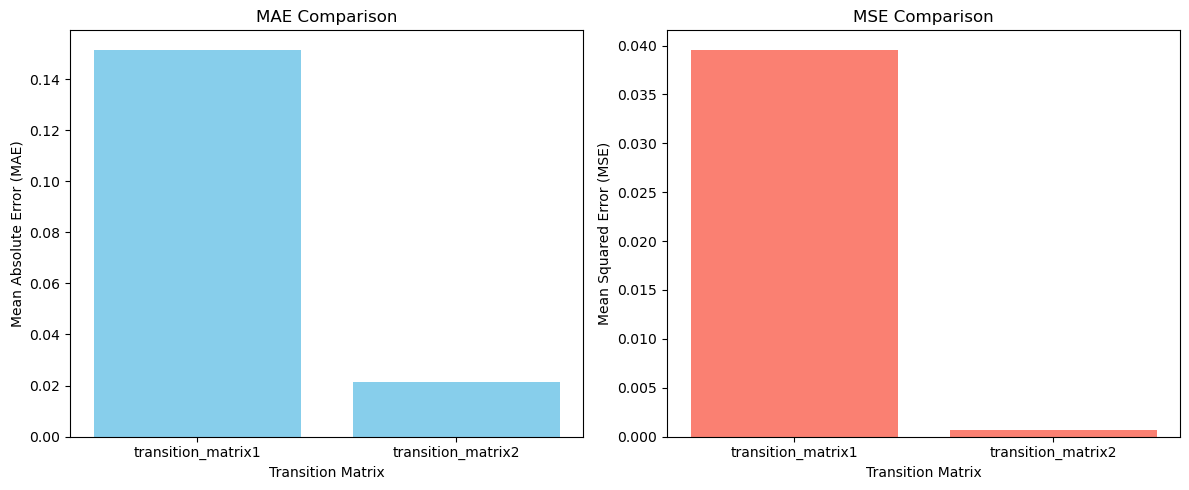

In [11]:
# Initialize the list to save the result
results = []

# Verify transition_matrix1 and T1
mae1, mse1 = validate_transition_estimator(transition_matrix1, T1)
results.append({'Matrix': 'transition_matrix1', 'MAE': mae1, 'MSE': mse1})

# Verify transition_matrix2 and T2
mae2, mse2 = validate_transition_estimator(transition_matrix2, T2)
results.append({'Matrix': 'transition_matrix2', 'MAE': mae2, 'MSE': mse2})

# Convert the result to a DataFrame
results_df = pd.DataFrame(results)

# Draw a comparison chart
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# MAE comparison
ax[0].bar(results_df['Matrix'], results_df['MAE'], color='skyblue')
ax[0].set_title("MAE Comparison")
ax[0].set_xlabel("Transition Matrix")
ax[0].set_ylabel("Mean Absolute Error (MAE)")

# MSE comparison
ax[1].bar(results_df['Matrix'], results_df['MSE'], color='salmon')
ax[1].set_title("MSE Comparison")
ax[1].set_xlabel("Transition Matrix")
ax[1].set_ylabel("Mean Squared Error (MSE)")

plt.tight_layout()
plt.show()

In [12]:
Xtr = dataset1['X_tr']
Str = dataset1['S_tr']
Xts = dataset1['X_ts']
Yts = dataset1['Y_ts']

cnn_accuracies = []
mlp_accuracies = []

T1_tensor = T1.clone().detach().to(device)

for i in range(T1_tensor.size(0)):
    for j in range(T1_tensor.size(1)):
        if i != j and T1_tensor[i, j] > 0.2:
            T1_tensor[i, j] = 0.2


# Main training cycle
for i in range(n_iterations):
    a = 0
    X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=a)
    a = a+1
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_val = X_val.reshape(-1, 1, 28, 28)
    Xts_reshaped = Xts.reshape(-1, 1, 28, 28)

    X_train = X_train / 255.0
    X_val = X_val / 255.0
    Xts_reshaped = Xts_reshaped / 255.0

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    Xts_tensor = torch.tensor(Xts_reshaped, dtype=torch.float32).to(device)
    Yts_tensor = torch.tensor(Yts, dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    test_loader = DataLoader(TensorDataset(Xts_tensor, Yts_tensor), batch_size=128, shuffle=False)
    
    # Suppose y_train contains labels for all training samples
    num_classes = 4
    class_counts = np.bincount(y_train, minlength=num_classes)  
    total_samples = len(y_train)

    # Calculate class weights
    class_weights = total_samples / (num_classes * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    class_weights = class_weights / class_weights.sum()  # Normalized class_weights

    cnn_model = CNN().to(device)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

    cnn_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_cnn.zero_grad()
            outputs = cnn_model(inputs)
            # Use a custom loss function with importance weighting and transition matrix
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, T1_tensor, class_weights)
            loss.backward()
            optimizer_cnn.step()

    # Evaluate CNN on the test set
    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    cnn_accuracy = correct / total
    cnn_accuracies.append(cnn_accuracy)
    

    mlp_model = MLP().to(device)
    # Change the optimizer to Adam and set the learning rate to 0.001
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

    mlp_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_mlp.zero_grad()
            outputs = mlp_model(inputs)
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, T1_tensor, class_weights)
            loss.backward()
            optimizer_mlp.step()

    # Evaluate MLP on test set
    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    mlp_accuracy = correct / total
    mlp_accuracies.append(mlp_accuracy)

mean_accuracy_cnn1_1 = np.mean(cnn_accuracies)
std_accuracy_cnn1_1 = np.std(cnn_accuracies)
best_accuracy_cnn1_1 = np.max(cnn_accuracies)
print("CNN Training completed.")
print(f"FashionMNIST0.3 average CNN Test Accuracy over {n_iterations} iterations: {mean_accuracy_cnn1_1:.4f}")
print(f"FashionMNIST0.3 standard Deviation of CNN Test Accuracy over {n_iterations} iterations: {std_accuracy_cnn1_1:.4f}")
print(f"FashionMNIST0.3 highest CNN Test Accuracy during iterations: {best_accuracy_cnn1_1:.4f}")

mean_accuracy_mlp1_1 = np.mean(mlp_accuracies)
std_accuracy_mlp1_1 = np.std(mlp_accuracies)
best_accuracy_mlp1_1 = np.max(mlp_accuracies)
print("MLP Training completed.")
print(f"FashionMNIST0.3 average MLP Test Accuracy over {n_iterations} iterations: {mean_accuracy_mlp1_1:.4f}")
print(f"FashionMNIST0.3 standard Deviation of MLP Test Accuracy over {n_iterations} iterations: {std_accuracy_mlp1_1:.4f}")
print(f"FashionMNIST0.3 highest MLP Test Accuracy during iterations: {best_accuracy_mlp1_1:.4f}")

CNN Training completed.
FashionMNIST0.3 average CNN Test Accuracy over 10 iterations: 0.8379
FashionMNIST0.3 standard Deviation of CNN Test Accuracy over 10 iterations: 0.0403
FashionMNIST0.3 highest CNN Test Accuracy during iterations: 0.8992
MLP Training completed.
FashionMNIST0.3 average MLP Test Accuracy over 10 iterations: 0.9083
FashionMNIST0.3 standard Deviation of MLP Test Accuracy over 10 iterations: 0.0162
FashionMNIST0.3 highest MLP Test Accuracy during iterations: 0.9315


In [13]:
Xtr = dataset2['X_tr']
Str = dataset2['S_tr']
Xts = dataset2['X_ts']
Yts = dataset2['Y_ts']

cnn_accuracies = []
mlp_accuracies = []

T2_tensor = T2.clone().detach().to(device)

for i in range(T2_tensor.size(0)):
    for j in range(T2_tensor.size(1)):
        if i != j and T2_tensor[i, j] > 0.2:
            T2_tensor[i, j] = 0.2
            
for i in range(n_iterations):
    a = 0
    X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=a)
    a = a+1
    X_train = X_train.reshape(-1, 1, 28, 28)
    X_val = X_val.reshape(-1, 1, 28, 28)
    Xts_reshaped = Xts.reshape(-1, 1, 28, 28)

    X_train = X_train / 255.0
    X_val = X_val / 255.0
    Xts_reshaped = Xts_reshaped / 255.0

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    Xts_tensor = torch.tensor(Xts_reshaped, dtype=torch.float32).to(device)
    Yts_tensor = torch.tensor(Yts, dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    test_loader = DataLoader(TensorDataset(Xts_tensor, Yts_tensor), batch_size=128, shuffle=False)
    
    num_classes = 4
    class_counts = np.bincount(y_train, minlength=num_classes) 
    total_samples = len(y_train)

    class_weights = total_samples / (num_classes * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    class_weights = class_weights / class_weights.sum() 

    cnn_model = CNN().to(device)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

    cnn_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_cnn.zero_grad()
            outputs = cnn_model(inputs)
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, T2_tensor, class_weights)
            loss.backward()
            optimizer_cnn.step()

    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    cnn_accuracy = correct / total
    cnn_accuracies.append(cnn_accuracy)

    mlp_model = MLP().to(device)
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)

    mlp_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_mlp.zero_grad()
            outputs = mlp_model(inputs)
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, T2_tensor, class_weights)
            loss.backward()
            optimizer_mlp.step()

    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    mlp_accuracy = correct / total
    mlp_accuracies.append(mlp_accuracy)
    
mean_accuracy_cnn2_1 = np.mean(cnn_accuracies)
std_accuracy_cnn2_1 = np.std(cnn_accuracies)
best_accuracy_cnn2_1 = np.max(cnn_accuracies)
print("CNN Training completed.")
print(f"FashionMNIST0.6 average CNN Test Accuracy over {n_iterations} iterations: {mean_accuracy_cnn2_1:.4f}")
print(f"FashionMNIST0.6 standard Deviation of CNN Test Accuracy over {n_iterations} iterations: {std_accuracy_cnn2_1:.4f}")
print(f"FashionMNIST0.6 highest CNN Test Accuracy during iterations: {best_accuracy_cnn2_1:.4f}")

mean_accuracy_mlp2_1 = np.mean(mlp_accuracies)
std_accuracy_mlp2_1 = np.std(mlp_accuracies)
best_accuracy_mlp2_1 = np.max(cnn_accuracies)
print("MLP Training completed.")
print(f"FashionMNIST0.6 average MLP Test Accuracy over {n_iterations} iterations: {mean_accuracy_mlp2_1:.4f}")
print(f"FashionMNIST0.6 standard Deviation of MLP Test Accuracy over {n_iterations} iterations: {std_accuracy_mlp2_1:.4f}")
print(f"FashionMNIST0.6 highest MLP Test Accuracy during iterations: {best_accuracy_mlp2_1:.4f}")

CNN Training completed.
FashionMNIST0.6 average CNN Test Accuracy over 10 iterations: 0.9210
FashionMNIST0.6 standard Deviation of CNN Test Accuracy over 10 iterations: 0.0086
FashionMNIST0.6 highest CNN Test Accuracy during iterations: 0.9323
MLP Training completed.
FashionMNIST0.6 average MLP Test Accuracy over 10 iterations: 0.9102
FashionMNIST0.6 standard Deviation of MLP Test Accuracy over 10 iterations: 0.0051
FashionMNIST0.6 highest MLP Test Accuracy during iterations: 0.9323


# CIFAR10

(20000, 32, 32, 3)
(20000,)
(4000, 32, 32, 3)
(4000,)
Test set contains 4 unique labels: [0 1 2 3]
Train set contains 4 unique labels: [0 1 2 3]


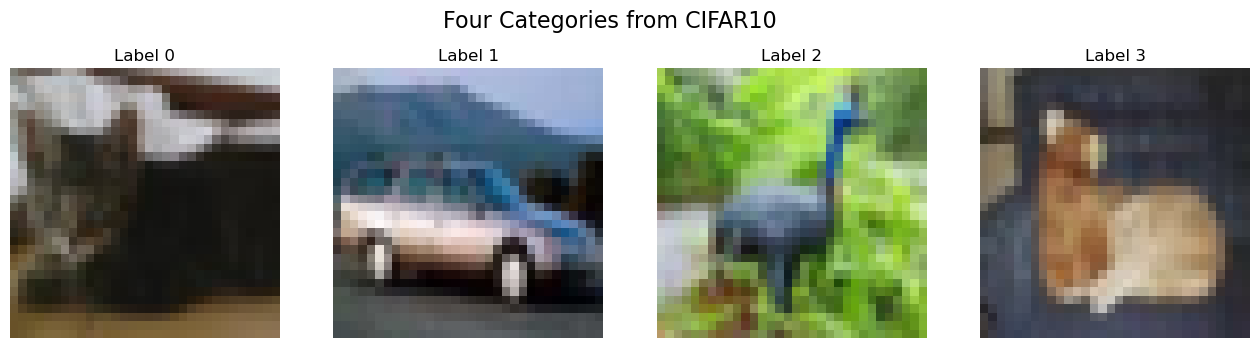

In [22]:
Xtr = dataset3['X_tr']
Str = dataset3['S_tr']
Xts = dataset3['X_ts']
Yts = dataset3['Y_ts']

print(Xtr.shape)
print(Str.shape)
print(Xts.shape)
print(Yts.shape)
unique_labels = np.unique(Yts)
print(f"Test set contains {len(unique_labels)} unique labels: {unique_labels}")
unique_labels = np.unique(Str)
print(f"Train set contains {len(unique_labels)} unique labels: {unique_labels}")

images = Xtr
unique_labels = np.unique(Str)
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, label in enumerate(unique_labels):
    image_idx = np.where(Str == label)[0][0]  
    axes[i].imshow(images[image_idx])  
    axes[i].set_title(f'Label {label}')
    axes[i].axis('off')

plt.suptitle('Four Categories from CIFAR10', fontsize=16)
plt.show()

In [23]:
X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=5328)

# Adjust dimensions to 32x32x3
X_train = X_train.reshape(-1, 3, 32, 32)
X_val = X_val.reshape(-1, 3, 32, 32)
Xts_reshaped = Xts.reshape(-1, 3, 32, 32)

X_train = X_train / 255.0
X_val = X_val / 255.0
Xts_reshaped = Xts_reshaped / 255.0


X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=128, shuffle=False)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Change the number of input channels to 3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Calculate the input dimensions of the full connection layer
        # The input is 32x32, and after two pools, the size is halved each time, so the output is 64x8x8
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  
        x = self.pool(torch.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

num_classes=4
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

T3 = estimate_transition_matrix(all_labels, all_preds, num_classes=4)
print("Final Transition Matrix of T3:\n", T3)

Final Transition Matrix of T3:
 tensor([[0.6524, 0.1056, 0.0618, 0.1803],
        [0.1918, 0.6887, 0.0304, 0.0891],
        [0.1508, 0.1518, 0.4772, 0.2202],
        [0.0977, 0.0677, 0.2157, 0.6190]])


In [24]:
n_iterations = 10
cnn_accuracies = []
mlp_accuracies = []

T3_tensor = T3.clone().detach().to(device)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(128 * 4 * 4, 128)  
        self.fc2 = nn.Linear(128, 4)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))  
        x = x.view(-1, 128 * 4 * 4)  
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 256)  
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

for i in range(T3_tensor.size(0)):
    for j in range(T3_tensor.size(1)):
        if i != j and T3_tensor[i, j] > 0.2:
            T3_tensor[i, j] = 0.2   
    
for i in range(n_iterations):
    a = 0
    X_train, X_val, y_train, y_val = train_test_split(Xtr, Str, test_size=0.2, random_state=a)
    a = a + 1
    X_train = X_train.reshape(-1, 3, 32, 32)
    X_val = X_val.reshape(-1, 3, 32, 32)
    Xts_reshaped = Xts.reshape(-1, 3, 32, 32)


    X_train = X_train / 255.0
    X_val = X_val / 255.0
    Xts_reshaped = Xts_reshaped / 255.0

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)
    Xts_tensor = torch.tensor(Xts_reshaped, dtype=torch.float32).to(device)
    Yts_tensor = torch.tensor(Yts, dtype=torch.long).to(device)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
    test_loader = DataLoader(TensorDataset(Xts_tensor, Yts_tensor), batch_size=128, shuffle=False)
    
    num_classes = 4
    class_counts = np.bincount(y_train, minlength=num_classes) 
    total_samples = len(y_train)

    class_weights = total_samples / (num_classes * class_counts)
    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    class_weights = class_weights / class_weights.sum()  
    cnn_model = CNN().to(device)
    optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)

    cnn_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_cnn.zero_grad()
            outputs = cnn_model(inputs)
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, T3_tensor, class_weights)
            loss.backward()
            optimizer_cnn.step()

    cnn_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = cnn_model(inputs)
            _, predicted = torch.max(outputs.data, 1) 
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    cnn_accuracy = correct / total
    cnn_accuracies.append(cnn_accuracy)
    

    mlp_model = MLP().to(device)
    optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
    mlp_model.train()
    for epoch in range(10):
        for inputs, labels in train_loader:
            optimizer_mlp.zero_grad()
            outputs = mlp_model(inputs)
            loss = standard_cross_entropy_loss_with_importance(outputs, labels, T3_tensor, class_weights)
            loss.backward()
            optimizer_mlp.step()

    mlp_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = mlp_model(inputs)
            _, predicted = torch.max(outputs.data, 1)  
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    mlp_accuracy = correct / total
    mlp_accuracies.append(mlp_accuracy)

mean_accuracy_cnn3 = np.mean(cnn_accuracies)
std_accuracy_cnn3 = np.std(cnn_accuracies)
best_accuracy_cnn3 = np.max(cnn_accuracies)
print("CNN Training completed.")
print(f"CIFAR10 average CNN Test Accuracy over {n_iterations} iterations: {mean_accuracy_cnn3:.4f}")
print(f"CIFAR10 standard Deviation of CNN Test Accuracy over {n_iterations} iterations: {std_accuracy_cnn3:.4f}")
print(f"CIFAR10 highest CNN Test Accuracy during iterations: {best_accuracy_cnn3:.4f}")

mean_accuracy_mlp3 = np.mean(mlp_accuracies)
std_accuracy_mlp3 = np.std(mlp_accuracies)
best_accuracy_mlp3 = np.max(mlp_accuracies)
print("MLP Training completed.")
print(f"CIFAR10 average MLP Test Accuracy over {n_iterations} iterations: {mean_accuracy_mlp3:.4f}")
print(f"CIFAR10 standard Deviation of MLP Test Accuracy over {n_iterations} iterations: {std_accuracy_mlp3:.4f}")
print(f"CIFAR10 highest MLP Test Accuracy during iterations: {best_accuracy_mlp3:.4f}")

CNN Training completed.
CIFAR10 average CNN Test Accuracy over 10 iterations: 0.6552
CIFAR10 standard Deviation of CNN Test Accuracy over 10 iterations: 0.0185
CIFAR10 highest CNN Test Accuracy during iterations: 0.6787
MLP Training completed.
CIFAR10 average MLP Test Accuracy over 10 iterations: 0.6372
CIFAR10 standard Deviation of MLP Test Accuracy over 10 iterations: 0.0171
CIFAR10 highest MLP Test Accuracy during iterations: 0.6655


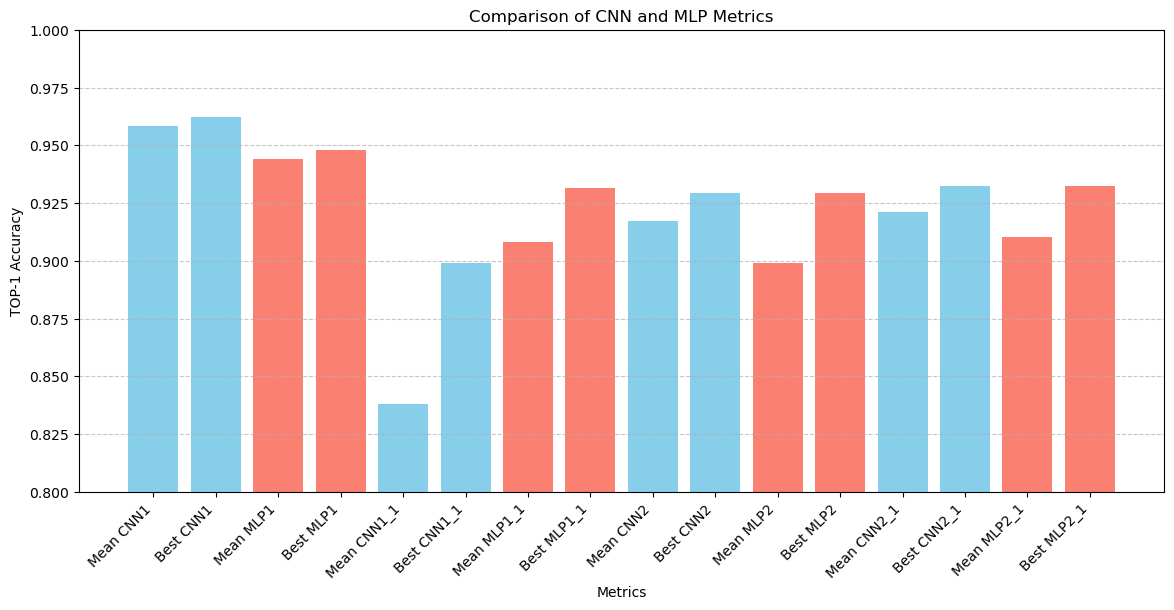

In [33]:
# Organize the data into bar chart data
labels = [
    'Mean CNN1', 'Best CNN1',
    'Mean MLP1', 'Best MLP1',
    'Mean CNN1_1', 'Best CNN1_1',
    'Mean MLP1_1', 'Best MLP1_1',
    'Mean CNN2', 'Best CNN2',
    'Mean MLP2', 'Best MLP2',
    'Mean CNN2_1', 'Best CNN2_1',
    'Mean MLP2_1', 'Best MLP2_1'
]

values = [
    mean_accuracy_cnn1, best_accuracy_cnn1,
    mean_accuracy_mlp1, best_accuracy_mlp1,
    mean_accuracy_cnn1_1, best_accuracy_cnn1_1,
    mean_accuracy_mlp1_1, best_accuracy_mlp1_1,
    mean_accuracy_cnn2, best_accuracy_cnn2,
    mean_accuracy_mlp2, best_accuracy_mlp2,
    mean_accuracy_cnn2_1, best_accuracy_cnn2_1,
    mean_accuracy_mlp2_1, best_accuracy_mlp2_1
]

plt.figure(figsize=(14, 6))
plt.bar(labels, values, color=['skyblue' if 'CNN' in label else 'salmon' for label in labels])
plt.xlabel('Metrics')
plt.ylabel('TOP-1 Accuracy')
plt.title('Comparison of CNN and MLP Metrics')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, 1)  # Set the Y-axis range to better show the difference
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

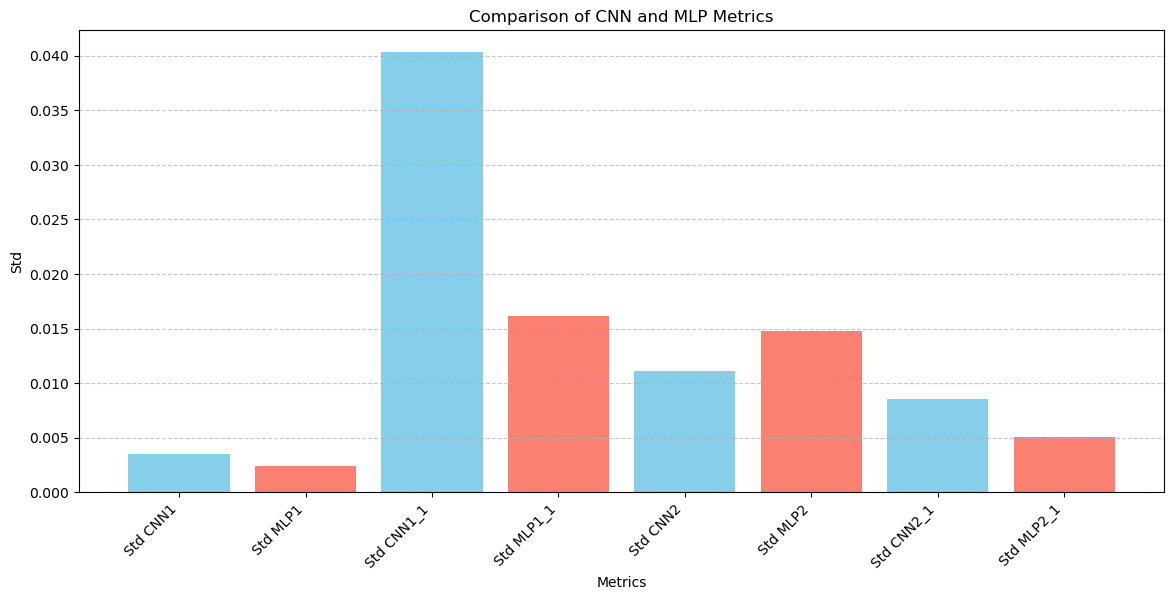

In [34]:
labels = [
    'Std CNN1', 'Std MLP1',
    'Std CNN1_1', 'Std MLP1_1',
    'Std CNN2', 'Std MLP2',
    'Std CNN2_1', 'Std MLP2_1'
]

values = [
    std_accuracy_cnn1, std_accuracy_mlp1,
    std_accuracy_cnn1_1, std_accuracy_mlp1_1,
    std_accuracy_cnn2, std_accuracy_mlp2,
    std_accuracy_cnn2_1, std_accuracy_mlp2_1
]

# Draw a bar chart
plt.figure(figsize=(14, 6))
plt.bar(labels, values, color=['skyblue' if 'CNN' in label else 'salmon' for label in labels])
plt.xlabel('Metrics')
plt.ylabel('Std')
plt.title('Comparison of CNN and MLP Metrics')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

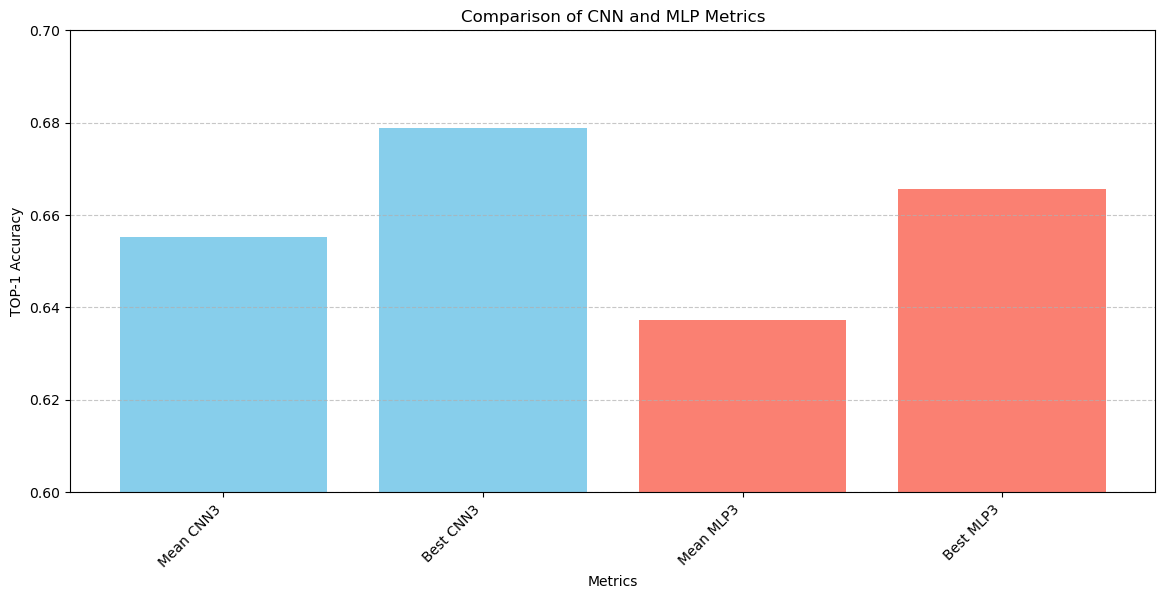

In [38]:
labels = [
    'Mean CNN3', 'Best CNN3',
    'Mean MLP3', 'Best MLP3'
]

values = [
    mean_accuracy_cnn3, best_accuracy_cnn3,
    mean_accuracy_mlp3, best_accuracy_mlp3
]

plt.figure(figsize=(14, 6))
plt.bar(labels, values, color=['skyblue' if 'CNN' in label else 'salmon' for label in labels])
plt.xlabel('Metrics')
plt.ylabel('TOP-1 Accuracy')
plt.title('Comparison of CNN and MLP Metrics')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.6, 0.7)  # Set the Y-axis range to better show the difference
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()